## MCC NMIBC Pre-repeat Urine MRD analysis

In [1]:
library(ggplot2)
library(tidyverse)
library(ComplexHeatmap)
library(maftools)
library(RColorBrewer)
library(readxl)
library(stats)
library(pROC)
library(stringr)
source("~/Desktop/puffin/R/helper_functions.R")
options(stringsAsFactors = FALSE)
options(repr.matrix.max.cols=75, repr.matrix.max.rows=50)

print(Sys.time())
print(sessionInfo())

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: grid

ComplexHeatmap version 2.16.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published researc

[1] "2023-08-08 12:40:31 PDT"
R version 4.3.0 (2023-04-21)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Ventura 13.4

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: internal

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] glue_1.6.2            pROC_1.18.4           readxl_1.4.3         
 [4] RColorBrewer_1.1-3    maftools_2.16.0       ComplexHeatmap_2.16.0
 [7] lubridate_1.9.2       forcats_1.0.0         stringr_1.5.0        
[10] dplyr_1.1.2           purrr_1.0.1           readr_2.1.4          
[13] tidyr_1.3.0           tibble_3.2.1          tidyverse_2.0.0      
[16] ggpl

## Beacon pipeline data location (3 work orders)
 http://10.10.0.131/lbwfresult/OutputByRun23/221014_A00934_0220_BHCY3YDMXY/dsrun1.7/lbwfresult1.7/

### pipeline notes on the mrd output file, see deepsea func callMRD and local annotated version of function
- mutationCount = length(variants.f), # count of Beacon sample variants that are somatic, and finalKeep or white.list
- mutationCount.mrd = length(variants.mrd), # number of quality filtered T00 personalized variants detected           
- mutationCount.mrd.f = length(variants.mrd.sig), ## number filtered T00 personal variants that have changed signif. in freuqncy from baseline (i.e. are not germlines mistaken for somatics)                       
- mrd.status = mrd.status,  ## total mrd.score across variants is >1.5
- tumorFraction = tumorFraction, # beacon sample tumorFraction calculated from variants.mrd.sig.f markers, or if none calculated from the other baseline-matching variants

In [2]:
# read in clinical data

# update to current PIDs
pid.table = read.csv("MCC_patientID_key_LT_06292023.csv", as.is=T)
oldpid_to_newpid = as.character(pid.table$New.patient.ID)
names(oldpid_to_newpid) <- as.character(pid.table$Old.patient.ID)
fix_PIDs <- function(col){
  out_col = trimws(gsub("-| ", "", col))
  out_col = gsub("MIBC017/NMIBC019", "NMIBC019", out_col) # keep with NMIBCs
  out_col = gsub("NMIBC003/MIBC021", "NMIBC003", out_col) # keep with NMIBCs
  out_col = ifelse(out_col %in% names(oldpid_to_newpid), oldpid_to_newpid[out_col], out_col)
  #stopifnot(all(!(grepl("^MIBC", out_col)))) # any MIBC samples in there?
  print(unique(out_col))
  warn_na(out_col)
  return(trimws(out_col))
}

df_clin = read.csv("./NMIBC_clinical_data_merged_2023-07-07.csv", as.is=T) 
#head(df_clin)
unique(df_clin$Index.Stage)
unique(df_clin$Repeat.Stage)

[1] "TaHG"                                               
[2] "T1HG"                                               
[3] "T1"                                                 
[4] "T1HG w/CIS"                                         
[5] "TaLG"                                               
[6] "CIS"                                                
[7] "TaHG w/CIS"                                         
[8] "Tis only (do not select if other histology present)"
[9] ""

[1] "TaHG w/CIS"                                              
 [2] "T0"                                                      
 [3] "T1HG"                                                    
 [4] "Tis only (do not select if other histology present)"     
 [5] ">=T2"                                                    
 [6] "CIS"                                                     
 [7] "T1"                                                      
 [8] "T1HG w/CIS"                                              
 [9] "TaHG"                                                    
[10] "T2 w/CIS (T1HG component sent to Predicine)"             
[11] "TaHG (but predominantly TaLG specimen sent to Predicine)"
[12] "T2 w/CIS"                                                
[13] "TaLG"                                                    
[14] ""

In [3]:
# extraction QC data
df_qc_all = read.csv("./NMIBC_all_lab_qc_2023-07-30.csv", as.is=T)
unique(df_qc_all$PatientID)
stopifnot(all(!duplicated(df_qc_all$SampleID.short)))
#write.csv(df_qc_all, glue("./NMIBC_all_lab_qc_{Sys.Date()}.csv"), row.names=F)
nrow(df_qc_all) # 244 samples

[1] 152237 165028 167162 171821 172749 173254 173350 173912 173975 174083
[11] 174872 174947 175325 175387 175425 175492 175526 175610 175648 175672
[21] 175725 175733 175854 175980 176349 176388 176828 176992 177967 178886
[31] 180264 182022 116381 172229 173075 173281 173334 174091 171374 172602
[41] 172586 169558 172851 171769 172530 172153 161922 173362 173509 173983
[51] 173359

[1] 244

In [4]:
## all sample NGSQC data
df_ngsqc.all = read.csv("PRDC-MOFFITT-NMIBC_Batch1n2n3_All_NGSQC_2023-06-29.csv", as.is=T)
nrow(df_ngsqc.all) #168
df_ngsqc.all = df_ngsqc.all %>% mutate(SampleType=tolower(ifelse(Specimen_type=="Buffy_Coat", "Buffy Coat",
                                                        ifelse(Specimen_type=="Urine Cell Pellet", "UCP",
                                                              ifelse(grepl("Supernatant", Specimen_type), "urine", Specimen_type)))))
df_ngsqc.all = df_ngsqc.all %>% filter(!grepl("fail", QC_Status, ignore.case=TRUE)) 
df_ngsqc.all  = df_ngsqc.all %>% mutate(trialVisitNum_ = sapply(str_split(df_ngsqc.all$trialVisitNum,"_"),"[",2),
                                          trialVisitNum = ifelse(grepl("_", trialVisitNum), trialVisitNum_, trialVisitNum))
#table(df_ngsqc.all$PatientID, df_ngsqc.all$Specimen_type)

df_ngsqc.urine.mrd = df_ngsqc.all %>% filter(SampleType=="urine", 
                                             grepl("Pre-Repeat", trialVisitNum), 
                                            !grepl("fail", QC_Status),
                                            grepl("mrd", Panel, ignore.case=T))
table(df_ngsqc.urine.mrd$PatientID, df_ngsqc.urine.mrd$SampleType) # 10 samples

[1] 168

        
         urine
  161922     1
  169558     1
  171769     1
  172229     1
  172530     1
  172586     1
  172851     1
  173334     1
  173362     1
  173983     1

In [12]:
# WGS data

# batch 1+2: 15 total, patients 11 and 18 did not have enough FFPE for processing, 2 failed
# ffpe 50X WGS
df_ffpe_lpwgs_a = standardize_names(read.csv("./data_batch1_and_2/FFPE_WES/LPWGS/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC_lpwgsQC.csv", as.is=T) %>%
                                        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")),
                                    "samples", warn=F)
df_ffpe_lpwgs_a$PatientID <- fix_PIDs(df_ffpe_lpwgs_a$PatientID)
# urine LPWGS 
df_urine_lpwgs_a1 = standardize_names(read.csv("./data_batch1_and_2/Urine-UCP/Urine-LPWGS/WGS_WOP00253_254_PRDC-MOFFITT-NMIBC_lpwgsQC.csv", as.is=T) %>%
                                        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")),
                             "samples", warn=F)
df_urine_lpwgs_a1$PatientID <- fix_PIDs(df_urine_lpwgs_a1$PatientID)
#df = df_all_a %>% filter(SampleType=="Supernatant") %>% filter(SampleID.short %!in% df_urine$SampleID.short)
# print(df)  # found missing samples in a2 below, bam files had been moved
# write.csv(df, "./missing_CNB_NMIBC_urine_samples.csv", row.names=F)
df_urine_lpwgs_a2 = standardize_names(read.csv("./data_batch1_and_2/Urine-UCP/Urine-LPWGS/WGS_WOP00253_WOP00254_PRDC-MOFFITT-NMIBC-22001_lpwgsQC_missing_05092023.csv", 
                                               as.is=T) %>%
                                        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")), "samples", warn=F)
df_urine_lpwgs_a2$PatientID <- fix_PIDs(df_urine_lpwgs_a2$PatientID)
df_all_lpwgs_a = rbind.common(df_ffpe_lpwgs_a, rbind.common(df_urine_lpwgs_a1, df_urine_lpwgs_a2))

# batch 3
# no low pass seq data for ffpes yet
# urine samples, low pass only, mrd TBD
df_urine_lpwgs_b = read.csv("./data_batch3_02222023/WOP00634_PRDC-MOFFITT-NMIBC-22001_WGS_combined_LPWGS_QC_Summary_all.csv") %>%
                mutate("SampleID.short"=make_SIDshort(SampleID, sid.format = "remove.suffix"))
df_urine_lpwgs_b$PatientID <- fix_PIDs(df_urine_lpwgs_b$PatientID)

## combine batches
df_lpwgs_all = rbind.common(df_all_lpwgs_a, df_urine_lpwgs_b) %>% filter(!grepl("fail", qcLabel, ignore.case=T))
df_lpwgs_all = merge.combine(df_lpwgs_all, df_qc_all %>% select(PatientID, SampleID.short, SampleType, StudyVisit))
stopifnot(all(!duplicated(df_lpwgs_all$SampleID.short)))
nrow(df_lpwgs_all) # 103
unique(df_lpwgs_all$SampleType)
unique(df_lpwgs_all$StudyVisit)

SampleID.short format: remove.suffix
 [1] "172229" "172586" "172602" "169558" "172851" "173334" "171769" "172530"
 [9] "173362" "173509" "161922" "173983"
SampleID.short format: remove.suffix
 [1] "172586" "173359" "169558" "161922" "172530" "173362" "172153" "172229"
 [9] "173334" "171374" "171769"
SampleID.short format: remove.suffix
 [1] "169558" "161922" "172530" "172602" "172851" "172586" "173983" "173359"
 [9] "173334" "171374" "173509" "171769"
SampleID.short format: remove.suffix
 [1] "175492" "152237" "173350" "175725" "171821" "174083" "182022" "174872"
 [9] "175425" "176388" "175854" "175980" "175672" "173975" "173912" "176349"
[17] "174947" "174091" "176828" "180264" "172749" "175325" "173281" "173075"
[25] "116381" "165028" "167162" "175648" "173254" "175610" "176992" "175526"
[33] "175733" "175387"


[1] 103

[1] "Tissue" "Urine"

[1] "IndexTURBT"       "RepeatTURBT"      "Post TURBT"       "Surveillance 1"  
[5] "Pre-Repeat TURBT" "Follow Up 1"

In [14]:
## create MRD data set

# batch 1+2 BEACON results for AUA
# see batch1_baseline_samples.csv

# select only samples with tissue for now
# ** samples without Index/Repeat available had WES run on pre-repeat turbt and beacon probes designed based on results

# batch 1 + 2
df_mrd1 = read.csv("./data_batch1_and_2/Urine-UCP/Pipeline_out_files_by_WO/WOP00252_PRDC-MOFFITT-NMIBC-22001_combined_MRDInfo_all.csv", as.is=T)
df_mrd2 = read.csv("./data_batch1_and_2/Urine-UCP/Pipeline_out_files_by_WO/WOP00253_PRDC-MOFFITT-NMIBC-22001_combined_MRDInfo_all.csv", as.is=T)
df_mrd3 = read.csv("./data_batch1_and_2/Urine-UCP/Pipeline_out_files_by_WO/WOP00254_PRDC-MOFFITT-NMIBC-22001_combined_MRDInfo_all.csv", as.is=T)
df_mrd = rbind(df_mrd1, df_mrd2, df_mrd3) %>% mutate("SampleID.short"=make_SIDshort(SampleID, sid.format="strict"))
#write.csv(df_mrd, file="./data/Urine-UCP/Urine_post_analysis/PRDC-MOFFITT-NMIBC-22001_MRD_Info_combined.csv", row.names=FALSE)

# note the UCPs have been extracted but not sequenced yet

df_mrd_pre = df_mrd %>% select(-PatientID) %>% #this col is blank for some reason
                        left_join(df_qc_all %>% select(SampleID.short, StudyVisit, SampleType, QC, PatientID), 
                                  by="SampleID.short") %>%
                        left_join(df_clin %>% select(PatientID, has.RepeatTURBT, has.IndexTURBT,
                                                     Index.Stage, Repeat.Stage, disease.positive),
                                  by="PatientID") %>%
     filter(QC != "Fail",
           SampleID %in% df_ngsqc.urine.mrd$SampleID) %>%
     mutate(utDNA.positive=ifelse(mrd.status,1,0))

df_mrd_pre$tumorFraction[df_mrd_pre$mrd.status=="FALSE"] <- 0.0 
df_mrd_pre = df_mrd_pre %>% left_join(df_lpwgs_all %>% select(SampleID.short,wgsTumorfrac_EM,wgsTumorfrac_ichorCNA, cnbScore),
                                      by="SampleID.short")
stopifnot(all(!duplicated(df_mrd_pre$SampleID.short))) # no duplicate samples

# df_out = df_mrd_pre %>% #left_join(df_concord_counts, by="PatientID") %>%
#                         select("PatientID","SampleID","SampleType","StudyVisit","has.IndexTURBT","has.repeatTURBT",
#                                "IndexPTStage","Repeat.Stage","disease.positive","utDNA.positive","tumorFraction")
# write.csv(df_out, file="./AUA/AUA_NMIBC_Abstract2_table.csv", row.names=F)

SampleID.short format: strict


     [,1] [,2]
[1,]    3    1
[2,]    5    2



	Fisher's Exact Test for Count Data

data:  mat
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.04150682 94.02422632
sample estimates:
odds ratio 
  1.180516 


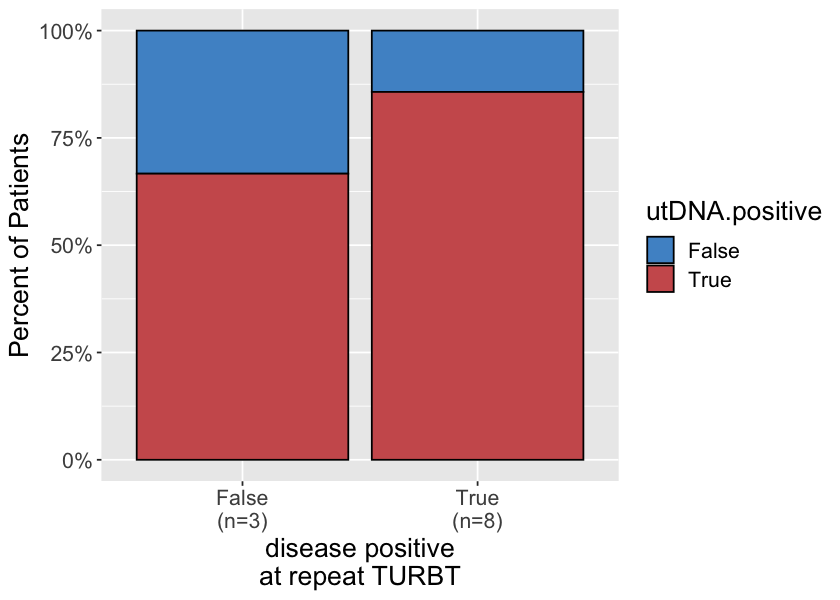

In [40]:
## correlation of mrd.status pipeline call with disease positivity
options(repr.plot.width=7, repr.plot.height=5)

ggplot(df_mrd_pre) +
  geom_bar(aes(x=factor(disease.positive), fill=factor(mrd.status)), position="fill", color="black") +
  scale_y_continuous(labels = scales::percent) +
  scale_fill_manual(name = "utDNA.positive", labels=c("False","True"), values=c("steelblue3", "indianred")) +
  scale_x_discrete(labels=c("False\n(n=3)","True\n(n=8)")) +
  labs(y="Percent of Patients", x="disease positive\nat repeat TURBT") +
  theme(text = element_text(size = 16))

mat = matrix(c(3,1,5,2), nrow=2, byrow=TRUE)
print(mat)
fisher.test(mat)

In [43]:
# correlation of MRD tumor fraction with disease positivity
source("~/Desktop/puffin/R/helper_functions.R")

df_mrd_pre$tumorFraction_lod = ifelse(is.na(df_mrd_pre$tumorFraction), 0.00005, df_mrd_pre$tumorFraction) #LOD proportion
df_mrd_pre$log_tumorFraction = log(df_mrd_pre$tumorFraction_lod*100) 
#View(quick_boxplot)
df_mrd_pre = df_mrd_pre %>% mutate("disease.positive"=factor(disease.positive))
pdf("./NMIBC_ucfDNA_BEACON_tumorFraction_boxplot_08042023.pdf", onefile = TRUE)

for (stat in c('tf.m.f','tf.f','tf.ext.f','maf','tf.baseline','maf.baseline','tumorfraction.baseline',
               'tumorfraction.baseline.adj','fc.tf.f','fc.tf.m.f','fc.tf.ext.f','tumorFraction')){
    g <- quick_boxplot(df_mrd_pre, x="disease.positive",y=stat, colors=c("FALSE"="blue","TRUE"="darkred"), log.axes = TRUE)
    show(g)
}
dev.off()

Complete cases tf.m.f by disease.positive: 10
# A tibble: 2 × 4
  disease.positive count legend      color  
  <chr>            <chr> <chr>       <chr>  
1 FALSE            3     FALSE (n=3) blue   
2 TRUE             7     TRUE (n=7)  darkred
FALSE median: 0.000344059075456777
TRUE median: 0.0194970056188002

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 2, p-value = 0.06825
alternative hypothesis: true location shift is not equal to 0

  disease.positive    tf.m.f   label
1            FALSE 0.5741412 p=0.068
2             TRUE        NA        


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


NULL
Complete cases tf.f by disease.positive: 9
# A tibble: 2 × 4
  disease.positive count legend      color  
  <chr>            <chr> <chr>       <chr>  
1 FALSE            2     FALSE (n=2) blue   
2 TRUE             7     TRUE (n=7)  darkred
FALSE median: 0.00196924870876187
TRUE median: 0.237278572787938

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 3, p-value = 0.3055
alternative hypothesis: true location shift is not equal to 0

  disease.positive      tf.f   label
1            FALSE 0.3711192 p=0.306
2             TRUE        NA        


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


NULL
Complete cases tf.ext.f by disease.positive: 9
# A tibble: 2 × 4
  disease.positive count legend      color  
  <chr>            <chr> <chr>       <chr>  
1 FALSE            2     FALSE (n=2) blue   
2 TRUE             7     TRUE (n=7)  darkred
FALSE median: 0.000872132831599699
TRUE median: 0.125320883396807

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 1, p-value = 0.1073
alternative hypothesis: true location shift is not equal to 0

  disease.positive  tf.ext.f   label
1            FALSE 0.5738745 p=0.107
2             TRUE        NA        


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


NULL
Complete cases maf by disease.positive: 10
# A tibble: 2 × 4
  disease.positive count legend      color  
  <chr>            <chr> <chr>       <chr>  
1 FALSE            3     FALSE (n=3) blue   
2 TRUE             7     TRUE (n=7)  darkred
FALSE median: 0.141735717400785
TRUE median: 8.84565499351492

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 4, p-value = 0.1715
alternative hypothesis: true location shift is not equal to 0

  disease.positive    maf   label
1            FALSE 72.207 p=0.171
2             TRUE     NA        


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


NULL
Complete cases tf.baseline by disease.positive: 8
# A tibble: 2 × 4
  disease.positive count legend      color  
  <chr>            <chr> <chr>       <chr>  
1 FALSE            2     FALSE (n=2) blue   
2 TRUE             6     TRUE (n=6)  darkred
FALSE median: 0.178118800842955
TRUE median: 0.186941862369685

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 4, p-value = 0.6171
alternative hypothesis: true location shift is not equal to 0

  disease.positive tf.baseline   label
1            FALSE   0.3992217 p=0.617
2             TRUE          NA        


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


NULL
Complete cases maf.baseline by disease.positive: 8
# A tibble: 2 × 4
  disease.positive count legend      color  
  <chr>            <chr> <chr>       <chr>  
1 FALSE            2     FALSE (n=2) blue   
2 TRUE             6     TRUE (n=6)  darkred
FALSE median: 55.9348455075738
TRUE median: 52.4313316266289

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 7, p-value = 0.8676
alternative hypothesis: true location shift is not equal to 0

  disease.positive maf.baseline   label
1            FALSE           NA        
2             TRUE      88.4003 p=0.868


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


NULL
Complete cases tumorfraction.baseline by disease.positive: 10
# A tibble: 2 × 4
  disease.positive count legend      color  
  <chr>            <chr> <chr>       <chr>  
1 FALSE            3     FALSE (n=3) blue   
2 TRUE             7     TRUE (n=7)  darkred
FALSE median: 0.347
TRUE median: 0.643

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 4, p-value = 0.1702
alternative hypothesis: true location shift is not equal to 0

  disease.positive tumorfraction.baseline  label
1            FALSE                  0.661 p=0.17
2             TRUE                     NA       


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


NULL
Complete cases tumorfraction.baseline.adj by disease.positive: 10
# A tibble: 2 × 4
  disease.positive count legend      color  
  <chr>            <chr> <chr>       <chr>  
1 FALSE            3     FALSE (n=3) blue   
2 TRUE             7     TRUE (n=7)  darkred
FALSE median: 0.589
TRUE median: 0.677

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 8, p-value = 0.6485
alternative hypothesis: true location shift is not equal to 0

  disease.positive tumorfraction.baseline.adj   label
1            FALSE                      0.705 p=0.649
2             TRUE                         NA        


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


NULL
Complete cases fc.tf.f by disease.positive: 8
# A tibble: 2 × 4
  disease.positive count legend      color  
  <chr>            <chr> <chr>       <chr>  
1 FALSE            2     FALSE (n=2) blue   
2 TRUE             6     TRUE (n=6)  darkred
FALSE median: 0.022970315516839
TRUE median: 0.832354590072224

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 1, p-value = 0.1336
alternative hypothesis: true location shift is not equal to 0

  disease.positive  fc.tf.f   label
1            FALSE 1.897512 p=0.134
2             TRUE       NA        


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


NULL
Complete cases fc.tf.m.f by disease.positive: 8
# A tibble: 2 × 4
  disease.positive count legend      color  
  <chr>            <chr> <chr>       <chr>  
1 FALSE            2     FALSE (n=2) blue   
2 TRUE             6     TRUE (n=6)  darkred
FALSE median: 0.0269044632286484
TRUE median: 0.438491029563

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 1, p-value = 0.1336
alternative hypothesis: true location shift is not equal to 0

  disease.positive fc.tf.m.f   label
1            FALSE  1.364162 p=0.134
2             TRUE        NA        


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


NULL
Complete cases fc.tf.ext.f by disease.positive: 8
# A tibble: 2 × 4
  disease.positive count legend      color  
  <chr>            <chr> <chr>       <chr>  
1 FALSE            2     FALSE (n=2) blue   
2 TRUE             6     TRUE (n=6)  darkred
FALSE median: 0.00988669892874145
TRUE median: 0.407741631857876

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 1, p-value = 0.1336
alternative hypothesis: true location shift is not equal to 0

  disease.positive fc.tf.ext.f   label
1            FALSE    1.408327 p=0.134
2             TRUE          NA        


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


NULL
Complete cases tumorFraction by disease.positive: 10
# A tibble: 2 × 4
  disease.positive count legend      color  
  <chr>            <chr> <chr>       <chr>  
1 FALSE            3     FALSE (n=3) blue   
2 TRUE             7     TRUE (n=7)  darkred
FALSE median: 0.000502795355321168
TRUE median: 0.162535748331745

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 3.5, p-value = 0.1373
alternative hypothesis: true location shift is not equal to 0

  disease.positive tumorFraction   label
1            FALSE     0.6641799 p=0.137
2             TRUE            NA        


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 2 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


NULL


pdf 
  2

In [6]:
## sumarize urine beacon
## number of baseline probes, # number of probes conf. detected 
    # mrd score # number new mutations detected #urine tumorFraction without new muts ## tumroFrac with new muts.
#select("PatientID","SampleID","SampleType","StudyVisit","has.IndexTURBT","has.repeatTURBT",
#                                "IndexPTStage","Repeat.Stage","disease.positive","utDNA.positive","tumorFraction_0")
mrd.table = df_mrd_pre %>% rename("N.baseline.muts.detected.mrdInfo"=mutationCount,
                                  "N.personal.probes.detected.mrdInfo"=mutationCount.mrd,
                                  "N.probes.detected.dynamic.mrdInfo"=mutationCount.mrd.f,
                                  "MRD.score"=mrd.score,
                                  "MRD.call"=mrd.status,
                                  "TF.all.muts.mrdInfo"=tumorfraction.baseline,
                                  "TF.dynamic.muts.mrdInfo"=tumorfraction.baseline.adj,
                                  "TF.dynamic.highqual.muts.mrdInfo"=tumorFraction) %>% 
               select(SampleID.short, PatientID, SampleType, StudyVisit, 
                      #"N.baseline.muts", #extract this one
                      N.baseline.muts.detected.mrdInfo, 
                      #"N.personal.probes", #extract this one
                      N.personal.probes.detected.mrdInfo, 
                      MRD.score, MRD.call,
                      TF.dynamic.muts.mrdInfo, 
                      TF.dynamic.highqual.muts.mrdInfo)
mrd.table

SampleID.short,PatientID,SampleType,StudyVisit,N.baseline.muts.detected.mrdInfo,N.personal.probes.detected.mrdInfo,MRD.score,MRD.call,TF.dynamic.muts.mrdInfo,TF.dynamic.highqual.muts.mrdInfo
<chr>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<lgl>,<dbl>,<dbl>
P219768,173362,Urine,Pre-Repeat TURBT,2,2,1.00,FALSE,0.281,0.0000000000
P219770,172229,Urine,Pre-Repeat TURBT,72,64,8.75,TRUE,0.643,0.6641799480
P219771,173334,Urine,Pre-Repeat TURBT,72,70,68.50,TRUE,0.676,0.0039131614
P219774,171769,Urine,Pre-Repeat TURBT,42,35,2.50,TRUE,0.685,0.2373843811
P217590,172851,Urine,Pre-Repeat TURBT,39,36,9.25,TRUE,0.677,0.1625357483
P217591,172586,Urine,Pre-Repeat TURBT,27,29,2.50,TRUE,0.705,0.3306003890
P217592,173983,Urine,Pre-Repeat TURBT,40,36,36.00,TRUE,0.683,0.0579642593
P217594,169558,Urine,Pre-Repeat TURBT,33,30,31.50,TRUE,0.380,0.0072417228
P217595,161922,Urine,Pre-Repeat TURBT,38,36,29.00,TRUE,0.702,0.0005027954


In [41]:
# refine tumor fraction plots
options(repr.plot.width=7, repr.plot.height=7)
options(repr.matrix.max.cols=100, repr.matrix.max.rows=100)

df_mrd_pre$tumorFraction_lod = ifelse(df_mrd_pre$tumorFraction == 0, 0.001, df_mrd_pre$tumorFraction) #LOD proportion 0.1%
df_mrd_pre$log_tumorFraction_pct = log(df_mrd_pre$tumorFraction_lod*100) 
min(df_mrd_pre$tumorFraction)
min(df_mrd_pre$tumorFraction_lod)
min(df_mrd_pre$log_tumorFraction_pct)


# log scale plot
# pdf("./NMIBC_ucfDNA_BEACON_log_tumorFraction_pct_boxplot_03032023.pdf")
# ggplot(df_mrd_pre, aes(x=factor(disease.positive), y=log_tumorFraction_pct, fill=factor(disease.positive))) +
#   geom_boxplot(outlier.shape = NA) +
#   geom_point(position=position_jitterdodge(), size=4, pch=1) +
#   #scale_y_continuous(labels = scales::percent) +
#   scale_fill_manual(name = "disease.positive", labels=c("False (n=3)","True (n=8)"), values=c("blue","darkred")) +
#   labs(y="log percent ucfDNA Tumor Fraction", x="") +
#   #ylim(min(df_mrd_pre$log_tumorFraction) - 0.1,4.5) +
#   theme(text = element_text(size = 20), axis.ticks = element_blank(), 
#         axis.text.x = element_blank())
# dev.off()

# # normal plot signif
# print("as percentages")
# print(mean(df_mrd_pre$tumorFraction_pct[df_mrd_pre$disease.positive==FALSE], na.rm=T))
# print(mean(df_mrd_pre$tumorFraction_pct[df_mrd_pre$disease.positive==TRUE], na.rm=T))
# res <- wilcox.test(tumorFraction_pct ~ factor(disease.positive),
#                    data = df_mrd_pre,
#                    exact = FALSE)
# res

# # remove outlier
# df_mrd_pre_ = df_mrd_pre %>% filter(tumorFraction<0.40)
# print(mean(df_mrd_pre_$tumorFraction[df_mrd_pre_$disease.positive==FALSE], na.rm=T))
# print(mean(df_mrd_pre_$tumorFraction[df_mrd_pre_$disease.positive==TRUE], na.rm=T))
# res <- wilcox.test(tumorFraction ~ factor(disease.positive),
#                    data = df_mrd_pre_,
#                    exact = FALSE)
# res

[1] 0

[1] 0.0005027954

[1] -2.990157

In [ ]:
# ROC of using panel TF to predict disease at repeat
options(repr.plot.width=5, repr.plot.height=5)

get_sens_spec <- function(df, label_col, score_col, title=NA, thresh=NA, target_sens=NA){
    print(sum(!is.na(df[1:nrow(df),score_col])))
    print(sprintf("case/control: %s / %s", sum(df[1:nrow(df),label_col]==1), sum(df[1:nrow(df),label_col]==0)))
    if (!is.na(thresh)){
      TP = nrow(df %>% filter(!!rlang::sym(label_col)=="late", !!rlang::sym(score_col) >= thresh))
      FN = nrow(df %>% filter(!!rlang::sym(label_col)=="late", !!rlang::sym(score_col) < thresh))
      TN = nrow(df %>% filter(!!rlang::sym(label_col)=="early", !!rlang::sym(score_col) < thresh))
      FP = nrow(df %>% filter(!!rlang::sym(label_col)=="early", !!rlang::sym(score_col) >= thresh))
      print(label_col %in% names(df))
      print(score_col %in% names(df))
      print(paste0("TP: ",TP))
      print(paste0("FP: ",FP))
      sens = TP/(TP + FN)
      spec = TN/(TN + FP)
      print(paste("Threshold Sens:", sens))
      print(paste("Threshold Spec:", spec))
        }
    
    pROC_obj <- roc_(data=df, response=label_col, 
                predictor=score_col, smooth = FALSE, plot=FALSE, direction="<") # controls score lower than cases
    if (!is.na(title)){
       plot.roc(pROC_obj, auc.polygon=TRUE, max.auc.polygon=FALSE, grid=TRUE,
            print.auc=TRUE, show.thres=TRUE, main=title)}
    
    print(coords(pROC_obj, x="best"))
    
    if (!is.na(target_sens)){
        print(sprintf("target sens %s", target_sens))
        print(coords(pROC_obj, x=target_sens, input="sensitivity", 
                     ret=c("threshold","specificity", "sensitivity")))
        }
    
    print(paste0("AUC: ", auc(pROC_obj)))
}

get_sens_spec(df_mrd_pre, "disease.positive", "tumorFraction_0", target_sens=0.90, title="predict by utDNA")

[1] 0.019
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                                Results
alpha (2-sided)               0.0100000
Power                         0.8000000
Simulated Power               0.9600000
Estimated relative effect p   0.0952381
N (total sample size needed) 21.3662452
t=n1/N                        0.7000000
n1 in Group 1                14.9563716
n2 in Group 2                 6.4098735
N rounded                    22.0000000
n1 rounded                   15.0000000
n2 rounded                    7.0000000
[1] 22
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                                Results
alpha (2-sided)               0.0200000
Power                         0.8000000
Simulated Power               0.9500000
Estimated relative effect p   0.0952381
N (total sample size needed) 17.9439995
t=n1/N   

sig.level,sample.size
<dbl>,<dbl>
0.01,22
0.02,19
0.03,17
0.04,16
0.05,15
0.06,13
0.07,13
0.08,12
0.09,12


[1] 0.162
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                                Results
alpha (2-sided)               0.0100000
Power                         0.8000000
Simulated Power               0.9400000
Estimated relative effect p   0.1666667
N (total sample size needed) 33.7612927
t=n1/N                        0.7000000
n1 in Group 1                23.6329049
n2 in Group 2                10.1283878
N rounded                    35.0000000
n1 rounded                   24.0000000
n2 rounded                   11.0000000
[1] 35
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                                Results
alpha (2-sided)               0.0200000
Power                         0.8000000
Simulated Power               0.9400000
Estimated relative effect p   0.1666667
N (total sample size needed) 28.5450661
t=n1/N   

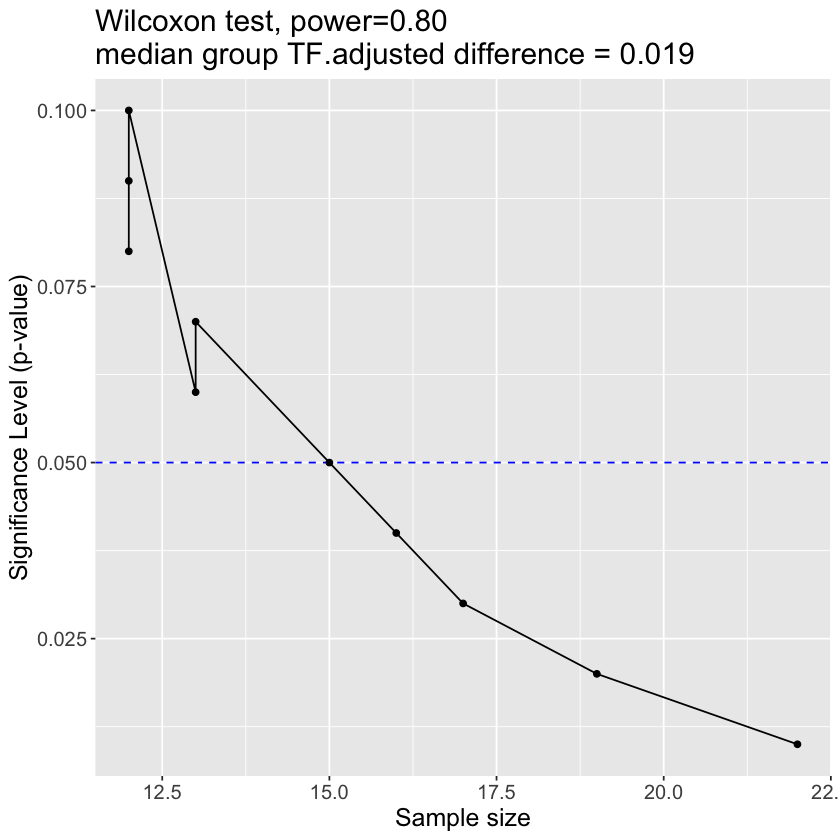

sig.level,sample.size
<dbl>,<dbl>
0.01,35
0.02,29
0.03,26
0.04,25
0.05,23
0.06,22
0.07,20
0.08,19
0.09,19


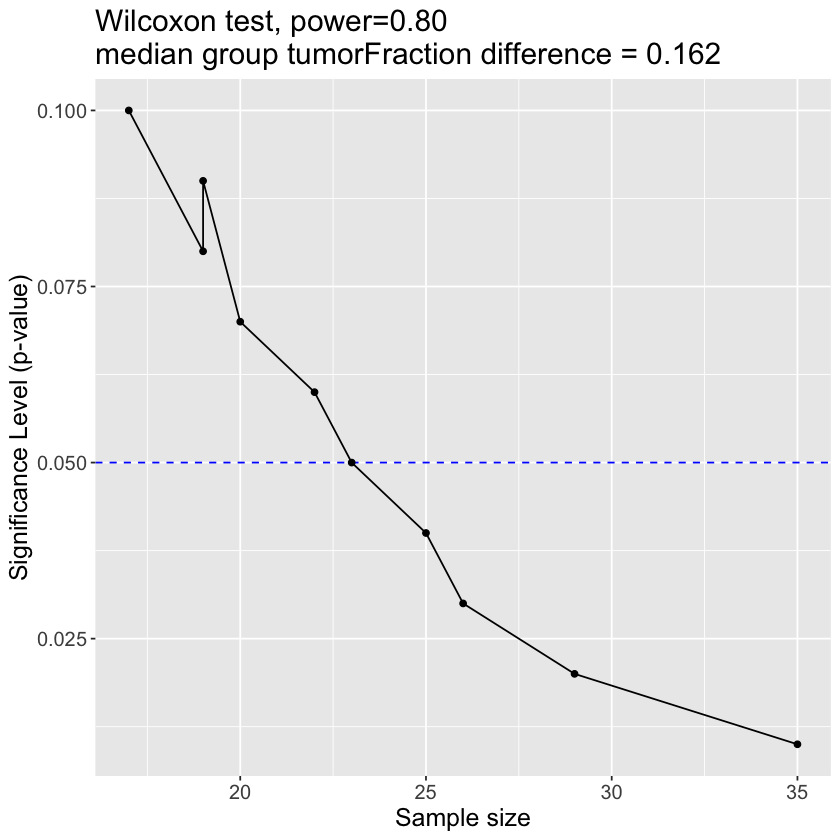

In [37]:
# power calc for validation cohort
# power curve: Significance vs. sample size given obsv. effect size
# https://cinnipatel.medium.com/power-curve-in-r-8a1e67fb2600

library(WMWssp)
# how many samples required to have 80% power to detect given effect size with confidence alpha=0.01 (p val, FPR)
plot_MWU <- function(case_vals, control_vals, power, metric=""){
    x = case_vals[!is.na(case_vals)]
    y = control_vals[!is.na(control_vals)]
    #effect_size = round(((mean(x) - mean(y))/mean(y)) * 100, 1)  #pct avg decrease from disease.positive to disease.nge
    effect_size = round((median(x) - median(y)), 3)
    print(effect_size)
    sig.level.list <- seq(.01,0.10,.01)  #Vector of sig..level 
    samp.out <- NULL
    for(a in sig.level.list){
      ssp <- WMWssp(x , 
                  y,
                  alpha = a, 
                  power = power, 
                  t = 7/10, 
                  simulation=T, nsim=100)
      res = summary(ssp)
      n.xxx  <-  res$Results[[9]]
      print(n.xxx)
      n.xxx <- data.frame(sig.level=a, sample.size=n.xxx)
      samp.out <- rbind(samp.out,n.xxx)
    }
    gg <- ggplot(samp.out, aes(sample.size,sig.level))+
      geom_line() + theme(text=element_text(size=15)) +
      #theme_minimal() +
      geom_hline(yintercept = .05,lty=2, color='blue') +
      geom_point() +
      labs(title=sprintf("Wilcoxon test, power=0.80\n%s = %s", metric, effect_size),
           y="Significance Level (p-value)",
           x="Sample size")
    show(gg)
    return(samp.out)
    }

plot_MWU(df_mrd_pre$tf.m.f[df_mrd_pre$disease.positive=="TRUE"],
        df_mrd_pre$tf.m.f[df_mrd_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group TF.adjusted difference")

plot_MWU(df_mrd_pre$tumorFraction[df_mrd_pre$disease.positive=="TRUE"],
        df_mrd_pre$tumorFraction[df_mrd_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group tumorFraction difference")

[1] 0.126
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                                Results
alpha (2-sided)               0.0100000
Power                         0.8000000
Simulated Power               1.0000000
Estimated relative effect p   0.1428571
N (total sample size needed) 23.7553633
t=n1/N                        0.7000000
n1 in Group 1                16.6287543
n2 in Group 2                 7.1266090
N rounded                    25.0000000
n1 rounded                   17.0000000
n2 rounded                    8.0000000
[1] 25
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                                Results
alpha (2-sided)               0.0200000
Power                         0.8000000
Simulated Power               0.9800000
Estimated relative effect p   0.1428571
N (total sample size needed) 19.9228483
t=n1/N   

sig.level,sample.size
<dbl>,<dbl>
0.01,25
0.02,20
0.03,19
0.04,17
0.05,16
0.06,15
0.07,14
0.08,13
0.09,13


[1] 5.706
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                                Results
alpha (2-sided)               0.0100000
Power                         0.8000000
Simulated Power               0.9900000
Estimated relative effect p   0.0952381
N (total sample size needed) 21.3662452
t=n1/N                        0.7000000
n1 in Group 1                14.9563716
n2 in Group 2                 6.4098735
N rounded                    22.0000000
n1 rounded                   15.0000000
n2 rounded                    7.0000000
[1] 22
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                                Results
alpha (2-sided)               0.0200000
Power                         0.8000000
Simulated Power               0.9100000
Estimated relative effect p   0.0952381
N (total sample size needed) 17.9439995
t=n1/N   

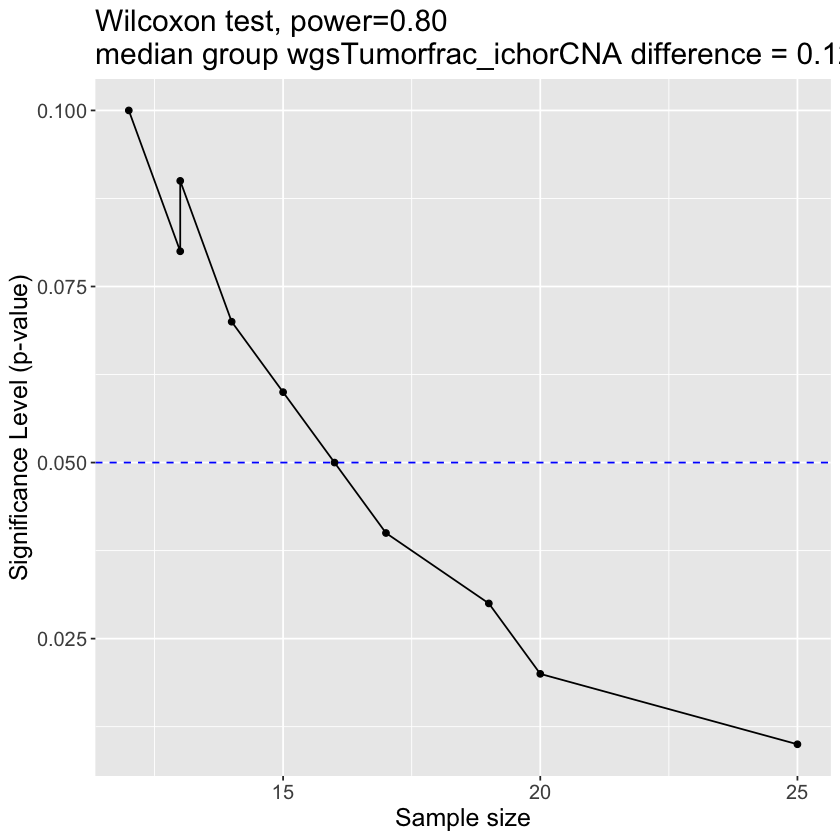

sig.level,sample.size
<dbl>,<dbl>
0.01,22
0.02,19
0.03,17
0.04,16
0.05,15
0.06,13
0.07,13
0.08,12
0.09,12


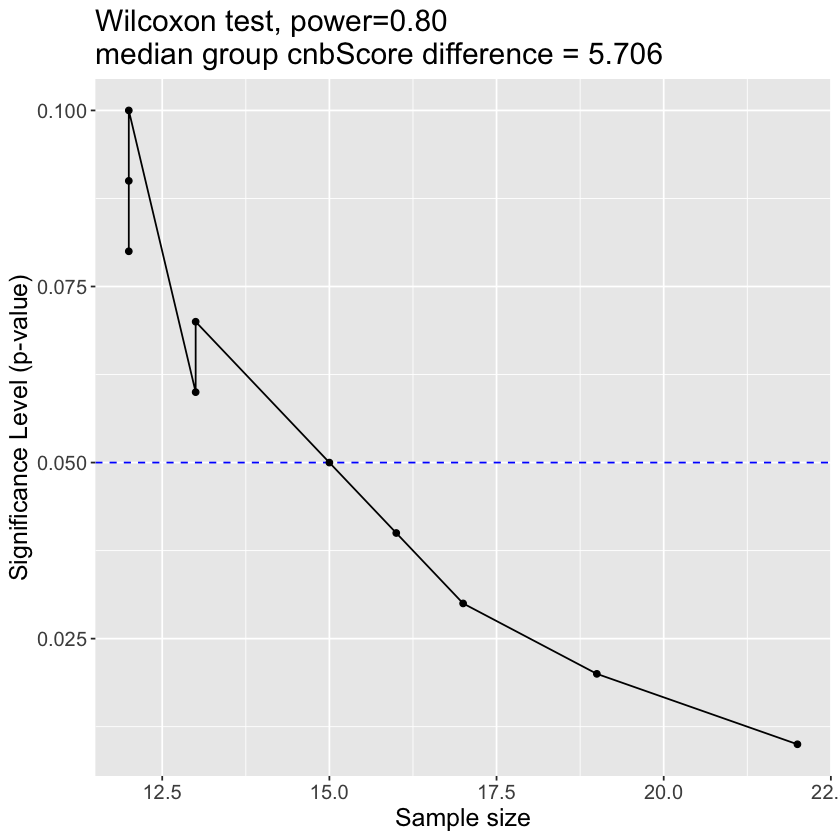

In [39]:
# plot_MWU(df_mrd_pre$wgsTumorfrac_EM[df_mrd_pre$disease.positive=="TRUE"],
#         df_mrd_pre$wgsTumorfrac_EM[df_mrd_pre$disease.positive=="FALSE"],
#         power=0.80, metric="median group wgsTumorfrac_EM difference")

plot_MWU(df_mrd_pre$wgsTumorfrac_ichorCNA[df_mrd_pre$disease.positive=="TRUE"],
        df_mrd_pre$wgsTumorfrac_ichorCNA[df_mrd_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group wgsTumorfrac_ichorCNA difference")

plot_MWU(df_mrd_pre$cnbScore[df_mrd_pre$disease.positive=="TRUE"],
        df_mrd_pre$cnbScore[df_mrd_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group cnbScore difference")